## Face and Facial Keypoint detection

See last cell in notebook for conclusions on methods for model's improvement.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

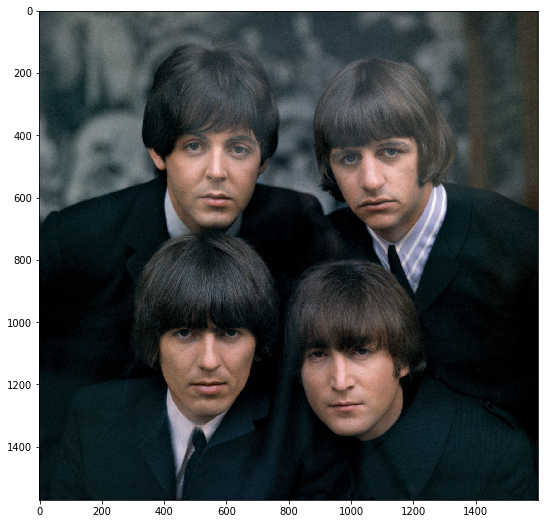

In [9]:
import cv2
# load in color image for face detection
image = cv2.imread('images/beatles.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

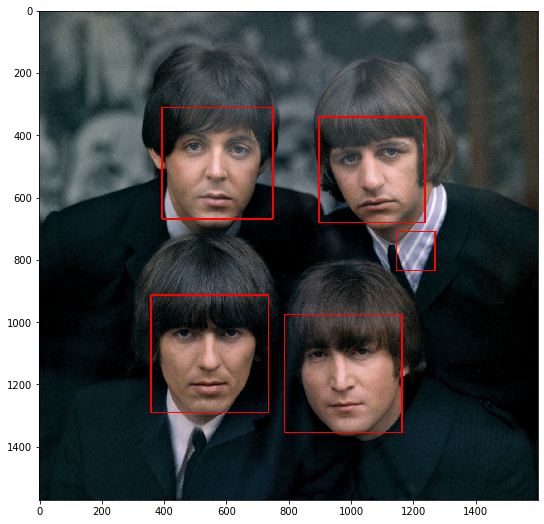

In [10]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [11]:
import torch
from models4 import Net

net = Net()

net.load_state_dict(torch.load('saved_models/KeshNet_4.pt'))

net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (drop4): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12800, out_features=512, bias=True)
  (dropFC): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=136, bias=True)
)

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [13]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=16):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

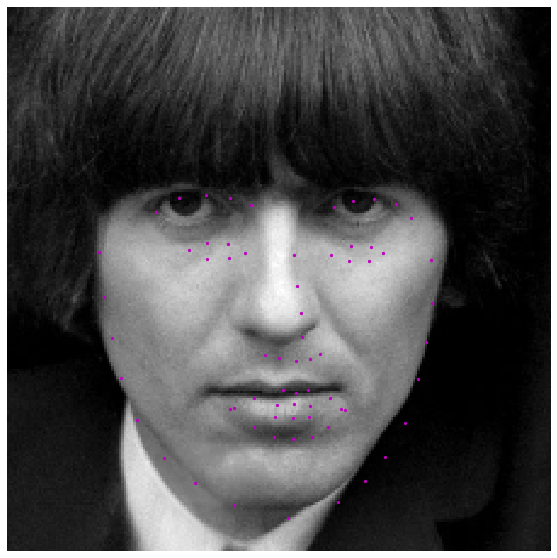

(1, 1, 224, 224)
torch.Size([1, 136])


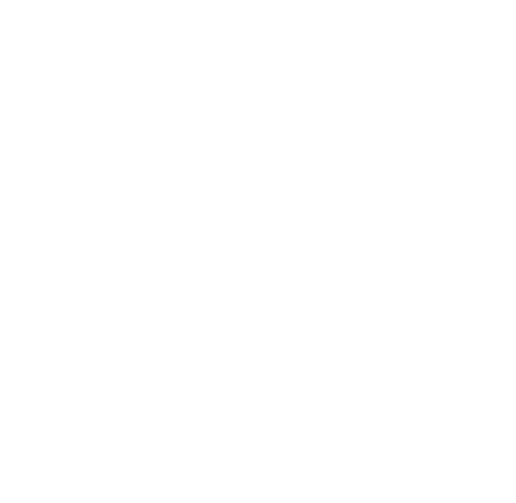

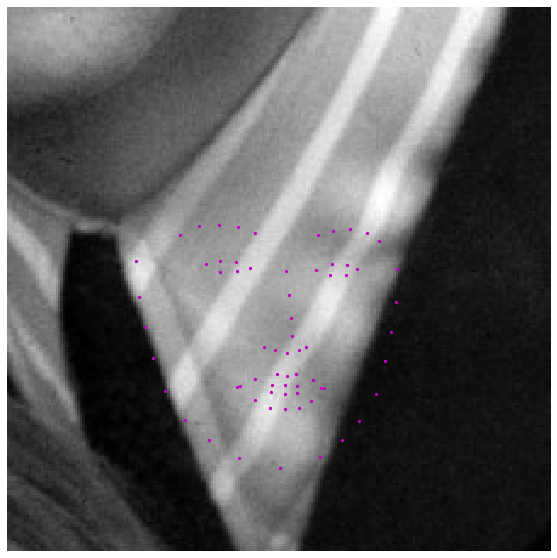

(1, 1, 224, 224)
torch.Size([1, 136])


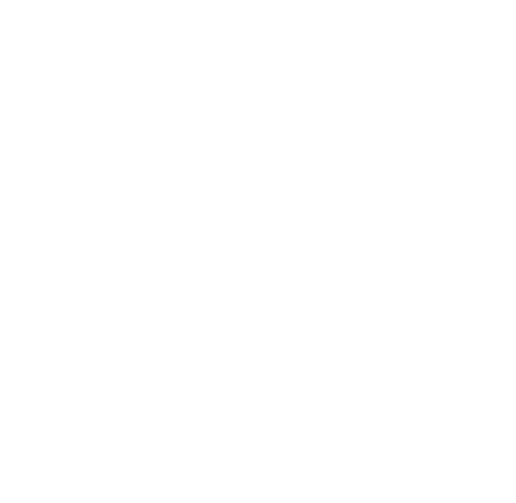

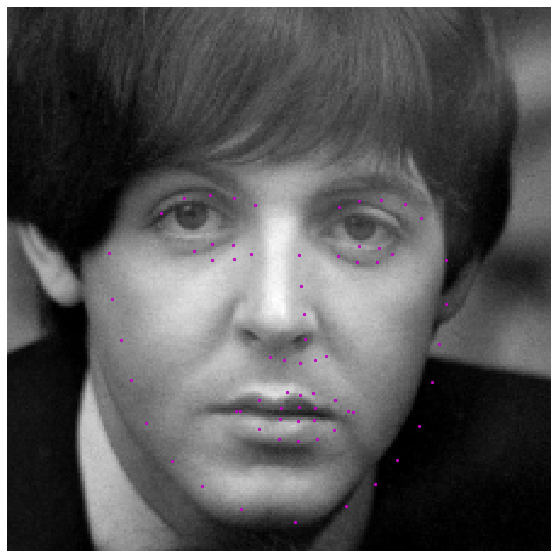

(1, 1, 224, 224)
torch.Size([1, 136])


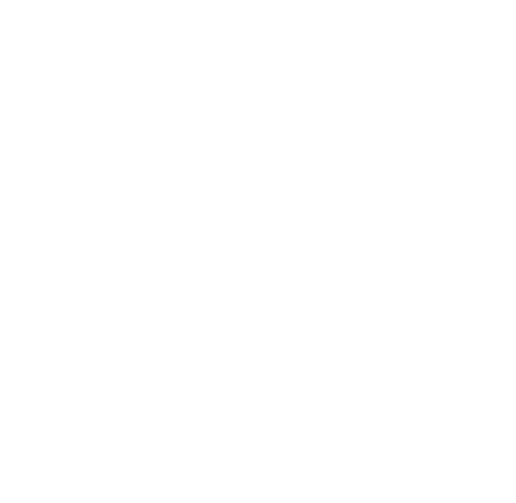

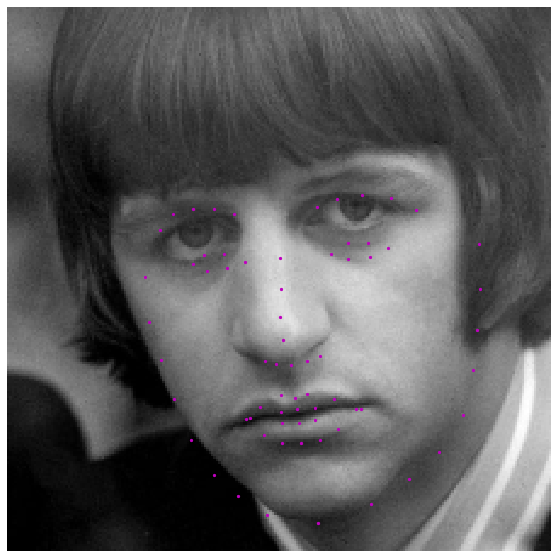

(1, 1, 224, 224)
torch.Size([1, 136])


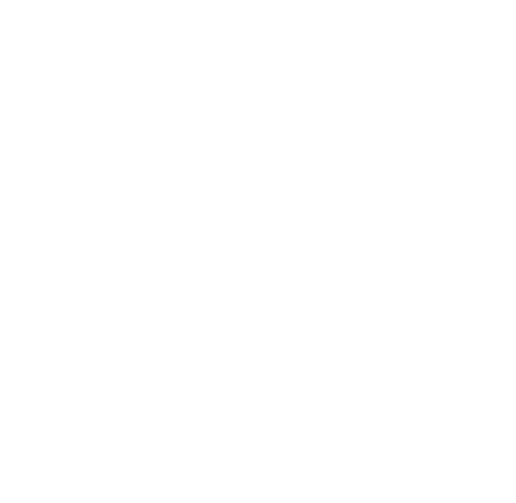

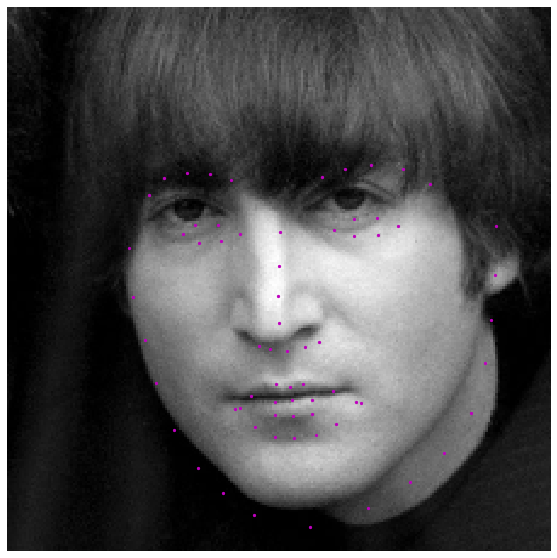

(1, 1, 224, 224)
torch.Size([1, 136])


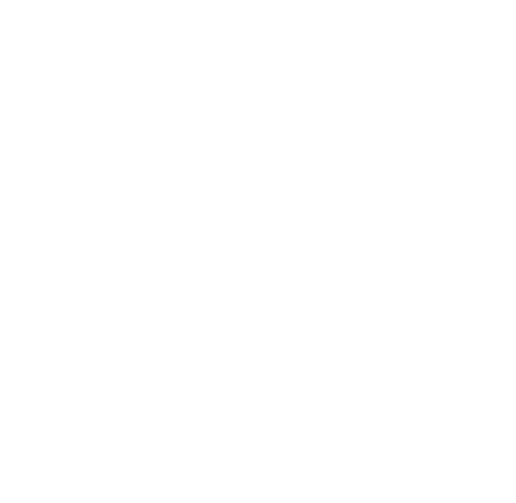

In [14]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image
    roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
    ## Convert the face from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = roi/255
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224)
    roi = cv2.resize(roi, (224,224))
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)  
    roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    roi = roi.transpose((2, 0, 1))
    # visualize function input as torch tensor
    roi = torch.from_numpy(roi)
            
    ## Make facial keypoint predictions using your loaded, trained network
    net = net.double()
    roi = roi.unsqueeze(0)
    output_pts = net(roi)
    predicted_key_pts = output_pts.view(output_pts.size()[0], 68, -1)
    visualize_output(roi, predicted_key_pts, None, 1)
    
    ## Display each detected face and the corresponding keypoints
    plt.figure(figsize=(9,9))
    plt.axis('off')
    
    # un-transform the image
    image_tx = roi.detach().numpy()
    print(image_tx.shape)
    image_tx = image_tx.squeeze()
    #image_tx = np.transpose(image_tx[0], (1, 2, 0))

    print(output_pts.size())


<strong>Of note:</strong> This CNN's identification of a face in Ringo's collar demonstrates the model's sensitivity to edge detection and shadow while identifying faces in an image.  An additional iteration of taining on this model should augment its dataset by including a) more images with less defined boundaries between subjects / background, b) more images with more stark lighting that generate deeper, more numerous shadows on subjects' faces.